# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [4]:
USER_NAME = u"Константиновский".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода Mini Batch Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \sigma(z) = \frac{1}{1+e^{-z}},\quad g(x) = <w,x>+w_{0} $$ 


$$ L(w) = -\frac{1}{b} \left[ \sum\limits_i^{i+b} \ln (\sigma(y^{(i)} g(x^{(i)}))) \right] $$

$$ \frac{\partial L}{\partial w_0} = -\frac{1}{b} \sum\limits_i^{i+b} (1-\sigma(y^{(i)}g(x^{(i)}))) y^{(i)} $$

$$ \frac{\partial L}{\partial w_i} = -\frac{1}{b} \sum\limits_k^{k+b} (1 - \sigma(y^{(k)}g(x^{(k)}))) y^{(k)} x_i^{(k)} $$

$$ w_i^{j+\frac{1}{2}} = w_i^j - \alpha_j \frac{\partial L}{\partial w_i}\bigg|_{w=w^j} $$
$$ w_i^{j+\frac{1}{2}} > 0:\quad w_i^{j+1} = \max(0, w_i^{j+\frac{1}{2}} - \frac{\alpha_j}{C}) $$

$$ w_i^{j+\frac{1}{2}} < 0:\quad w_i^{j+1} = \min(0, w_i^{j+\frac{1}{2}} + \frac{\alpha_j}{C}) $$
$$ w_i^{j+\frac{1}{2}} = 0:\quad w_i^{j+1} = 0 $$

## Имплементация (5 баллов)

In [2]:
#%%pycodestyle


from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        
        batch = 5
        classes = np.unique(y)
        yy = np.ones(y.shape)
        yy[y == classes[1]] = -1
        N = y.size
        XX = np.c_[np.ones(N), X]
        self.w = np.ones(XX.shape[1], dtype=np.float64)
        self.errors = []
        
        for n_epoch in range(1, self.max_epoch + 1):
            index = np.arange(N)
            np.random.shuffle(index)
            reg = 1 / self.C / batch * self.alpha / n_epoch
            for j in range(0, N, batch):
                grad=0
                for i in index[j:j+batch]:
                    sigma = 1 / (1 + np.exp(- yy[i] * np.dot(self.w, XX[i, :])))
                    grad = grad - (1 / batch * (1 - sigma) * yy[i] * XX[i, :])
                w = self.w - grad * self.alpha / n_epoch

                self.w[w > 0] = np.maximum(0, w[w > 0] - reg)
                self.w[w < 0] = np.minimum(0, w[w < 0] + reg)
                self.w[w == 0] = 0

                self.errors.append(1 / N * np.sum(np.log(1 + np.exp(
                    - yy * np.sum(self.w * XX, axis=1)))))
            
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        XX = np.c_[np.ones(X.shape[0]), X]
        y_hat = np.sum(XX * self.w, axis=1) > 0
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        XX = np.c_[np.ones(X.shape[0]), X]
        proba1 = 1 / (1 + np.exp(np.sum(XX * self.w, axis=1)))
        y_hat_proba = np.c_[proba1, 1 - proba1]

        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

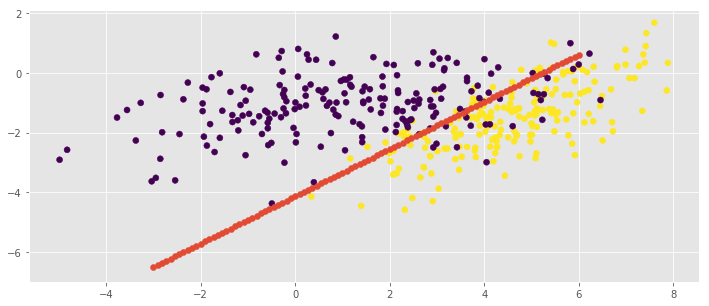

In [10]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

sgd = MySGDClassifier(alpha=10, max_epoch=100, C=1000)
sgd.fit(X, y)

plt.scatter(X[:,0], X[:,1], c=y)
X_help = np.linspace(-3, 6, num=100)
plt.scatter(X_help, - (sgd.w[0] + sgd.w[1] * X_help) / sgd.w[2])

#plt.scatter(X[:,0], X[:,1], c=y)

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [11]:
from sklearn.datasets import make_classification

In [12]:
X, y = make_classification(n_samples=10000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

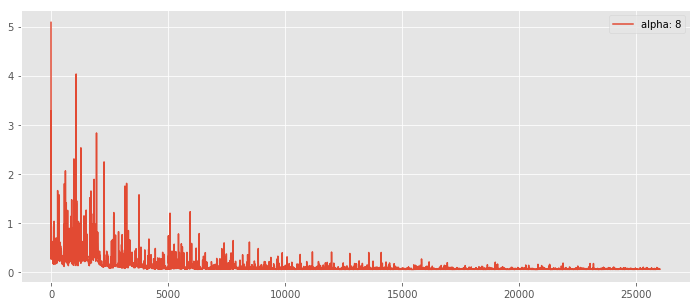

In [13]:
for a in np.arange(8, 9, 1):
    sgd = MySGDClassifier(alpha=a, max_epoch=13, C=50)
    sgd.fit(X, y)
    plt.plot(range(len(sgd.errors)), sgd.errors, label='alpha: ' + str(format(round(a, 3))))
plt.legend()


## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

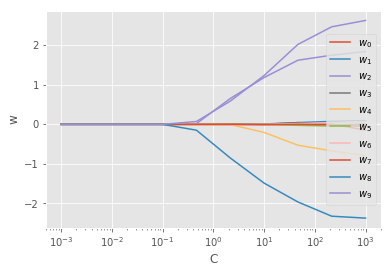

In [9]:
max_epoch = 10
w = np.zeros((10, 11))

for i, c in enumerate(np.logspace(3, -3, 10)):
    sgd = MySGDClassifier(alpha=0.5, max_epoch=max_epoch, C=c)
    sgd.fit(X, y)
    w[i, :] = sgd.w
    
for i in range(10):   
    plt.plot(np.logspace(3, -3, 10), w[:, i], label='$w_{%d}$' % i)
    plt.xscale('log')
plt.legend()


# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [3]:
# Загрузка данных целиком
df_list = []
#for chunk in range(1,5):
#    filepath = './trainingData_tabular_chunk%d.csv' % chunk
#    df_list.append(pd.read_csv(filepath, sep=','))
#df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [4]:
df_data.shape

(500000, 45)

In [5]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [6]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [7]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [8]:
## Youd Code Here
np.unique(df_data.opponent_hero_card_id).size

9

In [9]:
np.unique(df_data.player_hero_card_id).size

9

In [10]:
df_data = pd.get_dummies(df_data, columns=['opponent_hero_card_id', 'player_hero_card_id'])
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [11]:
## Youd Code Here
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [14]:
X_train = df_data.iloc[:10000, 1:].values
y_train = df_data.iloc[:10000, 0].values

print(X_train.shape)
print(y_train.shape)

(10000, 59)
(10000,)


In [15]:
model = Pipeline([('StandardScaler', StandardScaler()),
                  ('MySGDClassifier', MySGDClassifier(max_epoch=10, C=100, alpha=1.5))])
model.fit(X_train, y_train)

C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Pipeline(memory=None,
     steps=[('StandardScaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('MySGDClassifier', MySGDClassifier(C=100, alpha=1.5, max_epoch=10))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [16]:
## Youd Code Here
from sklearn.metrics import roc_auc_score

df_list = []

for i in range(5, 8):
    filepath = './testData_tabular_chunk%d.csv' % i
    df_list.append(pd.read_csv(filepath, sep=','))
df_test = pd.concat(df_list)

df_test.head().T

,0,1,2,3,4
gamestate_id,1304374.0,4383331.0,3544947.0,4282915.0,4327924.0
decision,NaN,NaN,NaN,NaN,NaN
turn,5.0,9.0,16.0,3.0,5.0
opponent.armor,0.0,0.0,0.0,0.0,0.0
opponent.attack,0.0,3.0,0.0,0.0,0.0
opponent.hero_card_id,981.0,754.0,798.0,326.0,25.0
opponent.hp,23.0,16.0,16.0,30.0,30.0
opponent.special_skill_used,0.0,0.0,1.0,0.0,0.0
opponent.weapon_durability,0.0,1.0,0.0,0.0,0.0
opponent.crystals_all,4.0,8.0,10.0,2.0,4.0


In [17]:
df_test.columns = df_test.columns.str.replace('.', '_')
df_test = df_test.set_index('gamestate_id')

In [18]:
df_test = pd.get_dummies(df_test, columns=['opponent_hero_card_id', 'player_hero_card_id'])

In [19]:
X_test = df_test.iloc[:, 1:].values

In [20]:
y_pred = model.predict_proba(X_test)
print(y_pred.shape)

C:\Users\Boris\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(1250000, 2)


In [21]:
y_test = pd.read_table('deprecated_testLabels.txt', names=['decision'])
print(y_test.shape)

(1250000, 1)


In [22]:
print(roc_auc_score(y_test, y_pred[:, 0]))

0.7428313697718374
